### Tweak 3: Augmentation — No Augmentation vs. Bag of Tricks (Flip, Rotation, Crop)

---
#### 1.1 Environment Check

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
import time
import copy

In [7]:
# reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# device selection: CUDA > MPS > CPU
if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(f'PyTorch version : {torch.__version__}')
print(f'Device          : {device}')
if device.type == 'cuda':
    print(f'GPU             : {torch.cuda.get_device_name(0)}')
    print(f'VRAM            : {torch.cuda.get_device_properties(0).total_mem / 1e9:.1f} GB')

PyTorch version : 2.5.1
Device          : mps


#### 1.2 The Subset (with configurable transforms)

Unlike previous notebooks, we now accept a **custom train transform** to test augmentation. The validation transform stays fixed (no augmentation — we always evaluate on clean data).

In [8]:
# standard normalization (same as baseline)
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD  = (0.2470, 0.2435, 0.2616)

def get_cifar10_subsets(train_transform, n_train=5000, n_test=1000, batch_size=64, num_workers=2):

    val_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD)
    ])

    full_train = torchvision.datasets.CIFAR10(
        root='../data', train=True, download=True, transform=train_transform)
    full_test = torchvision.datasets.CIFAR10(
        root='../data', train=False, download=True, transform=val_transform)

    train_subset = Subset(full_train, range(n_train))
    test_subset  = Subset(full_test,  range(n_test))

    train_loader = DataLoader(train_subset, batch_size=batch_size,
                              shuffle=True, num_workers=num_workers)
    val_loader   = DataLoader(test_subset,  batch_size=batch_size,
                              shuffle=False, num_workers=num_workers)

    return train_loader, val_loader, full_train.classes

#### 1.3 Define Transforms

| Name | Transforms |
|---|---|
| **No Augmentation** | ToTensor -> Normalize |
| **Bag of Tricks** | RandomHorizontalFlip -> RandomRotation(15 deg) -> RandomCrop(32, pad=4) -> ToTensor -> Normalize |

In [9]:
# Transform A: No augmentation (baseline)
transform_none = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD)
])

# Transform B: "Bag of Tricks" augmentation
transform_augmented = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD)
])

print('Transform A (No Augmentation):')
print(transform_none)
print()
print('Transform B (Bag of Tricks):')
print(transform_augmented)

Transform A (No Augmentation):
Compose(
    ToTensor()
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2435, 0.2616))
)

Transform B (Bag of Tricks):
Compose(
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
    RandomCrop(size=(32, 32), padding=4)
    ToTensor()
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2435, 0.2616))
)


#### 1.4 Visualize Augmentation Effects

/Users/pranayvishwakarma/Desktop/CIFAR-10-subset-CNN-experiments/venv/lib/python3.12/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


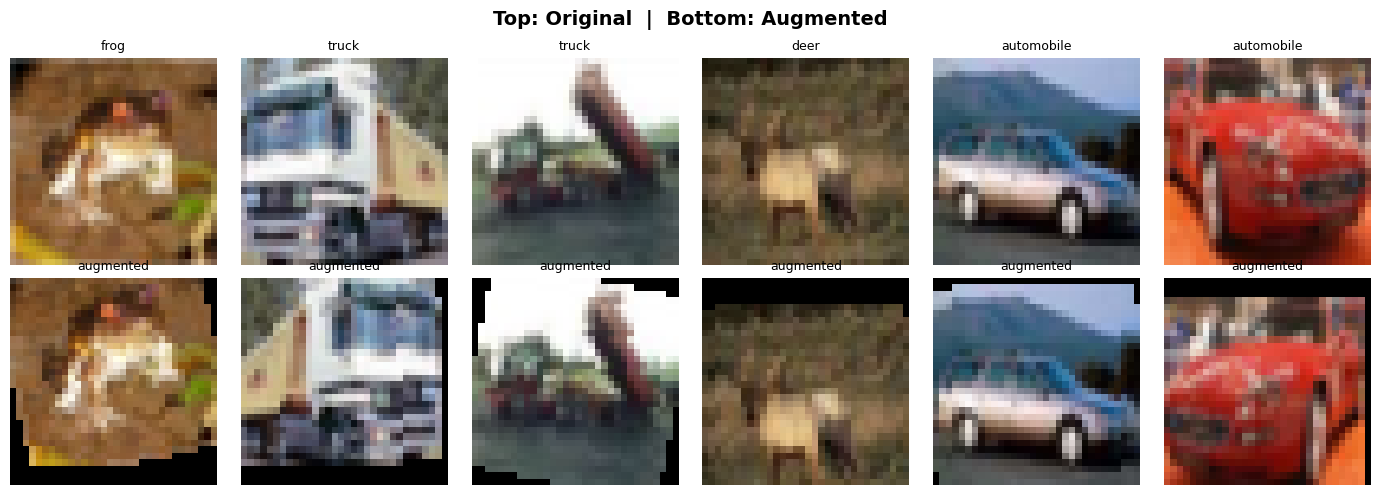

In [10]:
# load a few raw images (no normalization) to visualize augmentation
raw_dataset = torchvision.datasets.CIFAR10(
    root='../data', train=True, download=False,
    transform=transforms.ToTensor())

aug_preview = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
])

fig, axes = plt.subplots(2, 6, figsize=(14, 5))
fig.suptitle('Top: Original  |  Bottom: Augmented', fontsize=14, fontweight='bold')

for i in range(6):
    img, label = raw_dataset[i]
    axes[0, i].imshow(img.permute(1, 2, 0))
    axes[0, i].set_title(raw_dataset.classes[label], fontsize=9)
    axes[0, i].axis('off')

    # apply augmentation to PIL image
    from PIL import Image
    pil_img = Image.fromarray(
        (img.permute(1, 2, 0).numpy() * 255).astype(np.uint8))
    aug_img = aug_preview(pil_img)
    axes[1, i].imshow(aug_img.permute(1, 2, 0))
    axes[1, i].set_title('augmented', fontsize=9)
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

#### 1.5 Evaluation Suite

In [11]:
def count_parameters(model):
    """Return total number of trainable parameters."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [12]:
@torch.no_grad()
def evaluate(model, dataloader, criterion, device):
    """Compute average loss and accuracy on a dataloader."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    avg_loss = running_loss / total
    accuracy = 100.0 * correct / total
    return avg_loss, accuracy

In [13]:
def train_model(model, train_loader, val_loader, criterion, optimizer,
                device, epochs=15):
    """
    Standard training loop. Returns history dict with per-epoch metrics.
    """
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [],   'val_acc': []
    }
    best_val_acc = 0.0
    best_weights = None

    for epoch in range(1, epochs + 1):
        # --- train ---
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / total
        train_acc  = 100.0 * correct / total

        # --- validate ---
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        # record
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # checkpoint best
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_weights = copy.deepcopy(model.state_dict())

        print(f'Epoch {epoch:3d}/{epochs}  |  '
              f'Train Loss: {train_loss:.4f}  Acc: {train_acc:.2f}%  |  '
              f'Val Loss: {val_loss:.4f}  Acc: {val_acc:.2f}%')

    # restore best weights
    if best_weights:
        model.load_state_dict(best_weights)
    print(f'\nBest validation accuracy: {best_val_acc:.2f}%')
    return history

In [14]:
def plot_history(history, title='Training History'):
    """Plot loss and accuracy curves side by side."""
    epochs = range(1, len(history['train_loss']) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # --- loss ---
    ax1.plot(epochs, history['train_loss'], 'o-', label='Train Loss')
    ax1.plot(epochs, history['val_loss'],   's-', label='Val Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title(f'{title} \u2014 Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # --- accuracy ---
    ax2.plot(epochs, history['train_acc'], 'o-', label='Train Acc')
    ax2.plot(epochs, history['val_acc'],   's-', label='Val Acc')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title(f'{title} \u2014 Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

---
### 2. Model Definition

In [15]:
class SimpleCNN(nn.Module):
    """
    Baseline 2-layer CNN (no regularization).
    Same architecture as Model 0.
    """

    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),   # 32x32 -> 32x32
            nn.ReLU(),
            nn.MaxPool2d(2),                               # 32x32 -> 16x16

            nn.Conv2d(16, 32, kernel_size=3, padding=1),  # 16x16 -> 16x16
            nn.ReLU(),
            nn.MaxPool2d(2),                               # 16x16 -> 8x8
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 8 * 8, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [17]:
model = SimpleCNN().to(device)
print(model)
print(f'\nTrainable parameters: {count_parameters(model):,}')

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2048, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

Trainable parameters: 268,650


---
### 3. Train Both Experiments

Same hyperparameters: **Adam (lr=0.001)** \u00b7 **CrossEntropyLoss** \u00b7 **15 epochs** \u00b7 **batch size 64**

| Experiment | Train Transform |
|---|---|
| Bag of Tricks | RandomHorizontalFlip -> RandomRotation(15 deg) -> RandomCrop(32, pad=4) -> ToTensor -> Normalize |

In [18]:
EPOCHS = 15  # complete pass through your entire training dataset
LR = 1e-3    # Learning Rate

# Reset seeds for reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Load data (Bag of Tricks transform)
train_loader, val_loader, classes = get_cifar10_subsets(transform_augmented)

print(f'Training samples : {len(train_loader.dataset)}')
print(f'Val samples      : {len(val_loader.dataset)}')

# Initialize fresh model
model = SimpleCNN().to(device)
print(f'Parameters       : {count_parameters(model):,}')

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

print(f'\nOptimizer : Adam (lr={LR})')
print(f'Loss fn   : CrossEntropyLoss')
print(f'Epochs    : {EPOCHS}')
print(f'Device    : {device}')
print('-' * 65)

start = time.time()
history = train_model(model, train_loader, val_loader, criterion,
                      optimizer, device, epochs=EPOCHS)
elapsed = time.time() - start

print(f'\nTraining time: {elapsed:.1f}s')

Files already downloaded and verified
Files already downloaded and verified
Training samples : 5000
Val samples      : 1000
Parameters       : 268,650

Optimizer : Adam (lr=0.001)
Loss fn   : CrossEntropyLoss
Epochs    : 15
Device    : mps
-----------------------------------------------------------------
Epoch   1/15  |  Train Loss: 2.0168  Acc: 26.68%  |  Val Loss: 1.8179  Acc: 35.40%
Epoch   2/15  |  Train Loss: 1.7740  Acc: 35.82%  |  Val Loss: 1.7178  Acc: 37.90%
Epoch   3/15  |  Train Loss: 1.6447  Acc: 39.46%  |  Val Loss: 1.5345  Acc: 45.30%
Epoch   4/15  |  Train Loss: 1.5716  Acc: 43.04%  |  Val Loss: 1.4914  Acc: 47.30%
Epoch   5/15  |  Train Loss: 1.5122  Acc: 45.10%  |  Val Loss: 1.4821  Acc: 47.40%
Epoch   6/15  |  Train Loss: 1.4874  Acc: 45.46%  |  Val Loss: 1.4457  Acc: 49.20%
Epoch   7/15  |  Train Loss: 1.4528  Acc: 46.78%  |  Val Loss: 1.4426  Acc: 50.20%
Epoch   8/15  |  Train Loss: 1.4230  Acc: 48.26%  |  Val Loss: 1.3731  Acc: 51.90%
Epoch   9/15  |  Train Loss: 1

---
### 4. Individual Training Curves

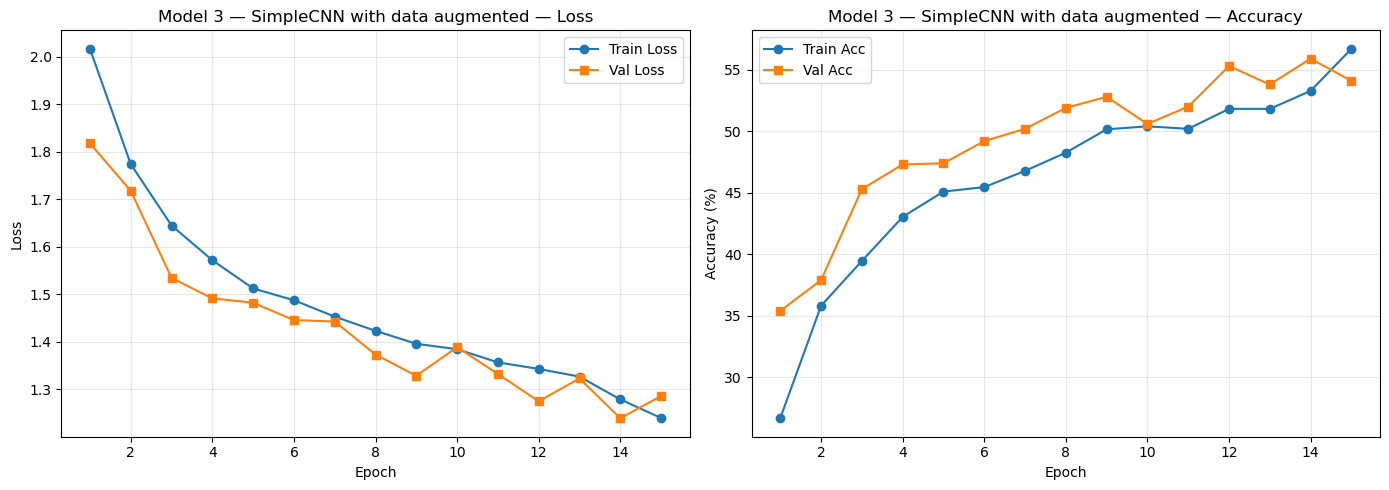

In [19]:
plot_history(history, title='Model 3 — SimpleCNN with data augmented')

---
### 5. Results Summary Table

In [22]:
final_train_acc = history['train_acc'][-1]
final_val_acc   = history['val_acc'][-1]
peak_val_acc    = max(history['val_acc'])
gap             = final_train_acc - final_val_acc

print('=' * 50)
print('         MODEL 3 — RESULTS SUMMARY')
print('=' * 50)
print(f'  Parameters       : {count_parameters(model):,}')
print(f'  Final Train Acc  : {final_train_acc:.2f}%')
print(f'  Final Val Acc    : {final_val_acc:.2f}%')
print(f'  Peak Val Acc     : {peak_val_acc:.2f}%')
print(f'  Train-Val Gap    : {gap:+.2f}%')
print(f'  Final Train Loss : {history["train_loss"][-1]:.4f}')
print(f'  Final Val Loss   : {history["val_loss"][-1]:.4f}')
print('=' * 50)

         MODEL 3 — RESULTS SUMMARY
  Parameters       : 268,650
  Final Train Acc  : 56.70%
  Final Val Acc    : 54.10%
  Peak Val Acc     : 55.90%
  Train-Val Gap    : +2.60%
  Final Train Loss : 1.2395
  Final Val Loss   : 1.2858
